In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!ls "/content/drive/My Drive/CNN_Project"

 ashs_model	    'Old notebooks'   Train_CNN_for_Melanoma.ipynb
 lesion_images.zip   split_data.py    train.csv


In [3]:
!pip install -q keras

In [4]:
pip install keras-preprocessing

In [5]:
import os
os.chdir("/content/drive/My Drive/CNN_Project")

In [ ]:
import os
import zipfile
local_zip = 'lesion_images.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('lesion_images')
zip_ref.close()

In [ ]:
!ls

In [ ]:
list = os.listdir("/content/drive/My Drive/CNN_Project/lesion_images")
number_files = len(list)
print(number_files)

33126


In [ ]:
!cat split_data.py

# -*- coding: utf-8 -*-
"""
Created on Tue Mar  2 14:49:41 2021

@author: Aisling
"""

import pandas as pd
#import numpy as np
from sklearn.model_selection import train_test_split
import os
import shutil

# Read csv content into dataframe
df = pd.read_csv('train.csv')

# Split into training and test data 85/15
train_df, test_df = train_test_split(df, test_size=0.15, random_state=0)

# Get relevant columns
relevant_train = train_df[['image_name', 'benign_malignant', 'target']]
relevant_test = test_df[['image_name', 'benign_malignant', 'target']]

if os.path.exists('training.csv'):
    os.remove('training.csv')
if os.path.exists('testing.csv'):
    os.remove('testing.csv')

# Write to training and test csvs
relevant_train.to_csv('training.csv')
relevant_test.to_csv('testing.csv')

# Get images in testing csv file 
test_images = test_df['image_name'].tolist() 

input_directory = "lesion_images/"
train_output_directory = "training/"
test_output_directory = "testing/"

# Get list of images 

In [ ]:
!python split_data.py

In [ ]:
!ls

In [ ]:
list = os.listdir("/content/drive/My Drive/CNN_Project/lesion_images")
number_files = len(list)
print(number_files)

0


In [ ]:
list = os.listdir("/content/drive/My Drive/CNN_Project/training")
number_files = len(list)
print(number_files)

28157


In [ ]:
list = os.listdir("/content/drive/My Drive/CNN_Project/testing")
number_files = len(list)
print(number_files)

4969


In [ ]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def append_ext(image):
    return image + ".jpg"

model = tf.keras.models.Sequential([
    
    # Input size of image 500x500 with 3 bytes color
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(512, 512, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # 1 output neuron, containing a value from 0-1, 0 being benign, 1 being malignant
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['accuracy'])


traindf = pd.read_csv("training.csv", dtype=str)
testdf = pd.read_csv("testing.csv", dtype=str)

# Apply .jpg extension
traindf["image_name"] = traindf["image_name"].apply(append_ext)
testdf["image_name"] = testdf["image_name"].apply(append_ext)


# Normalize data and split 15% for validation
training_datagen = ImageDataGenerator(rescale=1/255, validation_split=0.15)
testing_datagen = ImageDataGenerator(rescale=1/255)

training_generator = training_datagen.flow_from_dataframe(
        dataframe = traindf, 
        directory="training/", 
        x_col="image_name", 
        y_col="benign_malignant", 
        subset="training",
        class_mode="binary", 
        shuffle='True',
        target_size=(512, 512), 
        batch_size=128) # Was 32

# Batch size 41 as exactly divides number of validation images (4223)
validation_generator = training_datagen.flow_from_dataframe(
        dataframe = traindf,
        directory="training/",
        x_col="image_name",
        y_col="benign_malignant", 
        subset="validation",
        class_mode="binary", 
        shuffle='True',
        target_size=(512, 512), 
        batch_size=41)

# Batch size to set to 1 as will be used in evaluation and needs to be divided evenly
testing_generator = testing_datagen.flow_from_dataframe(
        dataframe = testdf,
        directory="testing/",
        x_col="image_name",
        y_col="benign_malignant", 
        class_mode="binary", 
        shuffle="False",
        target_size=(512, 512), 
        batch_size=1)

step_size_train = training_generator.n//training_generator.batch_size
step_size_valid = validation_generator.n//validation_generator.batch_size
step_size_test = testing_generator.n//testing_generator.batch_size


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 510, 510, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 255, 255, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 253, 253, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 124, 124, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 60, 64)        3

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Found 23934 validated image filenames belonging to 2 classes.
Found 4223 validated image filenames belonging to 2 classes.
Found 4969 validated image filenames belonging to 2 classes.


In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
history = model.fit(x=training_generator,
                    steps_per_epoch = step_size_train,
                    validation_data = validation_generator,
                    validation_steps = step_size_valid,
                    epochs=5
)

Epoch 1/5
186/186 [==============================] - 318s 2s/step - loss: 0.1243 - accuracy: 0.9826 - val_loss: 0.0987 - val_accuracy: 0.9799
Epoch 2/5
186/186 [==============================] - 265s 1s/step - loss: 0.0909 - accuracy: 0.9826 - val_loss: 0.0917 - val_accuracy: 0.9801
Epoch 3/5
186/186 [==============================] - 274s 1s/step - loss: 0.0918 - accuracy: 0.9827 - val_loss: 0.0962 - val_accuracy: 0.9799
Epoch 4/5
186/186 [==============================] - 274s 1s/step - loss: 0.0884 - accuracy: 0.9826 - val_loss: 0.1073 - val_accuracy: 0.9799
Epoch 5/5
186/186 [==============================] - 262s 1s/step - loss: 0.0881 - accuracy: 0.9826 - val_loss: 0.0963 - val_accuracy: 0.9799


In [ ]:
model.evaluate(x=validation_generator, steps=step_size_valid)

103/103 [==============================] - 38s 368ms/step - loss: 0.0963 - accuracy: 0.9799


[0.09627891331911087, 0.9798721075057983]

In [ ]:
model.evaluate(testing_generator, steps=step_size_test)

4969/4969 [==============================] - 63s 13ms/step - loss: 0.0844 - accuracy: 0.9833


[0.08437058329582214, 0.9832964539527893]

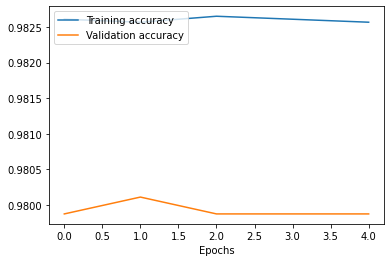

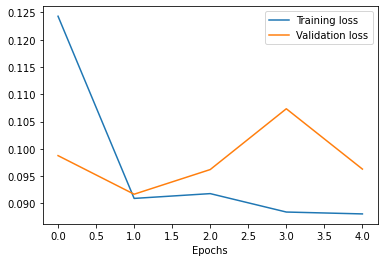

In [ ]:

#plotting accuracy
plt.plot(history.history['accuracy'],label='Training accuracy')
plt.plot(history.history['val_accuracy'],label='Validation accuracy')
plt.legend(loc = "upper left")
plt.xlabel('Epochs')
plt.savefig('training_validation_accuracy.png')
plt.show()

#plotting loss
plt.plot(history.history['loss'],label='Training loss')
plt.plot(history.history['val_loss'],label='Validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.savefig('training_validation_loss.png')
plt.show()

In [ ]:
!pip install tensorflowjs

In [ ]:
import tensorflowjs as tfjs

In [ ]:
tfjs.converters.save_keras_model(model, 'CNN_model')

In [ ]:
!ls

CNN_for_Melanoma.ipynb	split_data.py  training
CNN_model		testing        training.csv
lesion_images		testing.csv    training_validation_accuracy.png
lesion_images.zip	train.csv      training_validation_loss.png


In [ ]:
tf.keras.models.save_model(model, "ashs_cnn_model")

In [ ]:
loaded = tf.keras.models.load_model(model, "ashs_cnn_model")

In [ ]:
testing_generator.reset()
pred=model.predict(testing_generator,
steps=step_size_test,
verbose=1)

4969/4969 [==============================] - 53s 11ms/step


In [ ]:
print(pred[0])
if pred[0]>0.5:
  print("likely malignant")
else:
  print("likely benign")
 

[0.02056363]
likely benign


In [ ]:
print(type(pred))
print(pred)

<class 'numpy.ndarray'>
[[0.02056363]
 [0.03664667]
 [0.02156436]
 ...
 [0.0265068 ]
 [0.03851157]
 [0.02060461]]


In [ ]:
from keras.preprocessing import image
from google.colab import files

uploaded = files.upload()

In [ ]:
for file in uploaded.keys():
 
  path = file
  img = image.load_img(path, target_size=(512, 512))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = x.astype('float32') # this line was missing
  x /= 255 # this line was missing too

  images = np.vstack([x]) # vertically stack arrays
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  
  if classes[0]>0.5:
    # rounded = np.ceil(classes[0])
    # print(rounded) 
    ans = float(classes[0]) 
    ans *= 100
    ans = round(ans, 2)
    print(str(ans) + "%")  
    print(file + " is showing signs of malignancy")
  else:
    # rounded = np.floor(classes[0])
    # print(rounded)
    ans = float(classes[0]) 
    ans *= 100
    ans = round(ans, 2)
    print(str(ans) + "%")  
    print(file + " is more likely benign\n")